This notebook is a collection of some things I've learned from GPT. It's a bit tricky without documentation so I hope that this can help. Contact: samchristian@mit.edu

I have tested and run this notebook on MIT supercloud. To take advantage of full memory usage, I recommend running this notebook on a full node vs. a small number of cores.

# Table of contents

* [Fundamental GPT objects](#fundamental)
* [Generating gauge fields](#gauge)
* [Computing propagators](#props)
* [Computing correlation functions](#corr)
    * [Two point functions](#twopoint)
    * [Three point functions](#threepoint)

In [1]:
# For installation instructions on MIT supercloud, see 
# https://gist.github.com/Sam-2727/3c283bd5d5521bde9742db198f03573e
import gpt as g

SharedMemoryNone: SharedMemoryAllocate 1073741824 GPU implementation 
0SharedMemoryNone:  SharedMemoryNone.cc acceleratorAllocDevice 1073741824bytes at 0x7f424d400000 for comms buffers 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the t

In [2]:
# some other packages we'll need
import numpy as np
import sys
import io
from os import path
import struct
from typing import Dict, List, Tuple
from xml.etree import ElementTree as ET

GPT is divided into three components: fundamental objects, QCD (i.e. classical non-neural network algorithms and toolkit to calculate other quantities), and machine learning.

Here I will mainly focus on the fundamental objects and QCD side of things, but I think learning the fundamental objects side of GPT is enough to then read and understand the machine learning code directly:
https://github.com/lehner/gpt/tree/8dc512b219149d0362d9278e68cf4ef6733f1d4e/lib/gpt/ml

# Fundamental GPT objects <a name="fundamental"></a>

There are two objects of interest in GPT: grids and lattices. 

Grids are named in reference to the underlying package Grid on which GPT is built. They are more fundamental and encode the type of data we are working with and also some details about how we want to work with that data (mpi layout or checkerboarding).

Lattices are wrapped on top of grid objects. They store specific instances of data we are working with and function in many respects like tensors (although tensors are different gpt objects). They can be indexed in many respects like numpy arrays, although there are a few differences, in particular how data is returned.

First let's create a grid object. The most basic instantiation of gpt grids is providing the spatial dimensions and float precision

For full details of other parameters, see https://github.com/lehner/gpt/blob/8dc512b219149d0362d9278e68cf4ef6733f1d4e/lib/gpt/core/grid.py#L106

In [3]:
# create a new grid of size x=8,y=8,z=8,t=16
# create with double precision floats
newGrid = g.grid([8,8,8,16],precision=g.double)

In [4]:
print(newGrid)

fdimensions = [8, 8, 8, 16]; mpi = [1, 1, 1, 1]; precision = double; checkerboard = full


In [5]:
newGrid

Note that printing a grid in a notebook is more informative than just calling it (which is sometimes erronously thought to be equivalent to printing in Jupyter notebooks).

Now let's create a lattice object. We need to create the lattice on top of our grid, and because lattice objects can be thought of in many respects as tensors, we need to specify what type of tensor we want. Note that because the spatial lattice sites are already specified in the grid object, we don't need to specify these when creating the lattice object.

In [6]:
# here we are creating a matrix object of spin and color.
# So at each point in spacetime we associate a (4x4x3x3)
# tensor (or 12x12 matrix).
newLattice = g.mspincolor(newGrid)

do NOT try printing lattice objects. GPT will try printing our every entry in the lattice. Instead, if you want to see what type of lattice you are working with, just call the object as below:

In [7]:
newLattice

lattice(ot_matrix_spin_color(4,3),double)

In [8]:
print(newLattice.grid) # check that this matches the grid we inputted

fdimensions = [8, 8, 8, 16]; mpi = [1, 1, 1, 1]; precision = double; checkerboard = full


We can index lattice matrix sites as [x,y,z,t]

In [9]:
newLattice[1,2,3,4].array.shape

(4, 4, 3, 3)

Once the lattice is indexed, we convert to a numpy array with the .array attribute, then find the shape of the returned numpy array. We see that the convention is [spin,spin,color,color]

We can access the values at specific lattice sites by accessing the lattice object directly.

Let's look at the color-color matrix associated with [x,y,z,t,s1,s2]=[1,2,3,4,3,2]

In [10]:
newLattice[1,2,3,4,3,2,:,:]

array([[[[[0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j]]]]])

One subtly is that when we access only spacetime indices [x,y,z,t], the object returned is a gpt tensor object which we need to convert to a numpy array, but when accessing also the underlying spin-color indices, the returned object is a numpy array. So newLattice[1,2,3,4,:,:,:,:] and newLattice[1,2,3,4].array return the same thing, but but the second is a bit faster.

Everything is zero now in our instantiation, but we can change that by providing a numpy array.

We need to make sure that our numpy array has the correct data type. Because we said that our data type was g.double, our numpy data type should be np.cdouble

In [11]:
arrayInput = np.reshape(np.linspace(0,1,9,dtype=np.cdouble),(3,3))
print(arrayInput)

[[0.   +0.j 0.125+0.j 0.25 +0.j]
 [0.375+0.j 0.5  +0.j 0.625+0.j]
 [0.75 +0.j 0.875+0.j 1.   +0.j]]


In [12]:
newLattice[1,2,3,4,3,2,:,:]=arrayInput

In [13]:
newLattice[1,2,3,4,3,2,:,:]

array([[[[[0.   +0.j, 0.125+0.j, 0.25 +0.j],
          [0.375+0.j, 0.5  +0.j, 0.625+0.j],
          [0.75 +0.j, 0.875+0.j, 1.   +0.j]]]]])

In [14]:
newLattice[1,2,3,4,0,0,:,:]

array([[[[[0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j]]]]])

**Important point:** Converting between numpy arrays and gpt objects is extremely slow, so it is best to work with just gpt objects or just numpy arrays whenever possible

In [15]:
%timeit newLattice[1,2,3,4,3,2,:,:]

2.56 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Some more lattice operations (useful for energy calculations)

Fortunately, we can perform most numpy operations on lattice objects, although things are usually a bit more brittle. Often, lattice operations are named

For example, we can multiply two lattices together.

In [16]:
# so we get a nonzero answer
numpyInput = np.reshape(np.arange(0,144,dtype=np.cdouble),(4,4,3,3))
newLattice[1,2,3,4,:,:,:,:]=numpyInput

In [17]:
expressionToEvaluate = newLattice*newLattice
newLatticeSquared = g(expressionToEvaluate)

GPT only evaluates expressions when wrapped with g(), so you can control where in your code you want the computationally intensive evaluation to occur.

The expression evaluation takes place as a tensor sum at each lattice site (unlike default numpy multiplication). So 

$L[x,y,z,t,s_1,s_3,c_1,c_3]=\sum_{s_2,c_2}L[x,y,z,t,s_1,s_2,c_1,c_2]L[x,y,z,t,s_2,s_3,c_2,c_3]$

In [18]:
# what we expect
summedResult = 0
for s in range(0,4):
    for c in range(0,3):
        summedResult+=numpyInput[0,s,0,c]*numpyInput[s,0,c,0]
print(summedResult)

(14802+0j)


In [19]:
#confirming result
newLatticeSquared[1,2,3,4,0,0,0,0]

array([[[[[14802.+0.j]]]]])

It should be mentioned briefly that vectors also exist in GPT, although I haven't used them too much

In [20]:
newLatticeVector = g.vspincolor(newGrid)

In [21]:
g(newLattice*newLatticeVector)

lattice(ot_vector_spin_color(4,3),double)

We'll come back to some more fundamental GPT operations in the course of things, but first:

# Generating gauge fields <a name="gauge"></a>

We will load in gauge configurations from previous computations in chroma. We could also compute in gpt, but that would take too long for a tutorial Jupyter notebook.

For a good tutorial on HMC gauge generation for pseudofermions of a two-flavor degenerate mass action, see https://homepages.uni-regensburg.de/~lec17310/teaching/wise2122/chapter13.pdf 

Note that in that tutorial, if wilson fermions are being used, some code should be changed. In particular, we should replace D_m with wilson_clover (as specified below in the propagator computation section), and critically, two_flavor_ratio_evenodd_schur with two_flavor_evenodd_schur and [D_m,D_pv] with D_m.

Below, I simply replicate Lehner's tutorial. Note that this is not the gauge generation we used in our study, I never got non-heatbath algorithms to work with wilson_clover on gpt (some issues with gradients). Perhaps you will fare better. This will take a while to run and probably requires a lot of memory:

In [ ]:
L = [8,8,8, 32]
grid = g.grid(L, g.double)
rng = g.random("test", "vectorized_ranlux24_24_64")
U = [g.project(x,"defect") for x in g.qcd.gauge.random(grid, rng)]
Nd = len(U)
# conjugate momenta
U_mom = g.group.cartesian(U)
rng.normal_element(U_mom)

# reproduce https://arxiv.org/pdf/hep-lat/0411006.pdf
a0 = g.qcd.scalar.action.mass_term()
a1 = g.qcd.gauge.action.improved_with_rectangle(2.13,-0.331)
D_m = g.qcd.fermion.mobius(U, M5=1.8, mass=0.04, Ls=2, b=1., c=0.,
 boundary_phases=[1,1,1,-1])
D_pv = g.qcd.fermion.mobius(U, M5=1.8, mass=1.0, Ls=2, b=1., c=0.,
 boundary_phases=[1,1,1,-1])
inv = g.algorithms.inverter
pc = g.qcd.fermion.preconditioner
g.default.set_verbose("cg_convergence", False)
g.default.set_verbose("cg", False)
cg = inv.cg({"eps": 1e-8, "maxiter": 1000})
a2 = g.qcd.pseudofermion.action.two_flavor_ratio_evenodd_schur([D_m, D_pv], cg)
P = g.vspincolor(D_m.F_grid_eo)
fields = U + [P]
sympl = g.algorithms.integrator.symplectic
show_force = False
def total_force():
    global show_force
    gauge_force = a1.gradient(U,U)
    fermion_force = a2.gradient(fields,U)
    if show_force:
        g.message("gauge force", (sum(g.norm2(gauge_force)) / 4 / P.grid.gsites)**0.5)
        g.message("fermion force", (sum(g.norm2(fermion_force)) / 4 / P.grid.gsites)**0.5)
        show_force = False
    return [g(x+y) for x,y in zip(gauge_force,fermion_force)]
ipU = sympl.update_p(U_mom, lambda: total_force())
iqUM = sympl.update_q(U, lambda: a0.gradient(U_mom, U_mom))
mdint = sympl.OMF4(5, ipU, iqUM)
metro = g.algorithms.markov.metropolis(rng)
def hamiltonian(draw):
    if draw:
        rng.normal_element(U_mom)
        a0v = a0(U_mom)
        a1v = a1(U)
        a2v = a2.draw(fields, rng)
    else:
        a0v = a0(U_mom)
        a1v = a1(U)
        a2v = a2(fields)
    return a0v + a1v + a2v, a1v + a2v
def hmc(tau):
    accrej = metro(U)
    h0, s0 = hamiltonian(True)
    mdint(tau)
    h1, s1 = hamiltonian(False)
    return [accrej(h1, h0), s1 - s0, h1 - h0]
plaquette_hmc = []
accept = 0
total = 0
for it in range(0,800):
    plaq = g.qcd.gauge.plaquette(U)
    g.save("iteration{}-{}".format(0,it),U)
    plaquette_hmc.append(plaq)
    show_force = it % 10 == 0
    a, dS, dH = hmc(0.6)
    print(a)
    accept += a
    total += 1
    if it % 1 == 0:
        g.message(f"HMC {it} has P = {plaq}, dS = {dS}, dH = {dH}, acceptance = {accept/total}")
    np.save("plaquette_hmc.npy",plaquette_hmc)

Say instead we want to read gauge configurations from chroma. This is what we did in practice, since we reused configurations from previous computations. If you're at MIT, I can direct you to the specific configurations we used.

Gauge configurations from chroma have some xml data before containing binary data. When reading them into gpt, we need to skip to the end of the xml and then load the binary data into a numpy array. We then put that numpy array into a lattice object before saving for later usage.

The only thing that might need modifying is that ">c8" command, depending on the data-precision used. See https://numpy.org/doc/stable/reference/arrays.dtypes.html

In [22]:
import numpy as np
import sys
import gpt as g
import io
from os import path
import struct
from typing import Dict, List, Tuple
from xml.etree import ElementTree as ET
def loadGauge(path,size):
    filename = path
    with open(filename, "rb") as f:
        meta: Dict[str, Tuple[int]] = {}
        buffer = f.read(8)
        while buffer != b"" and buffer != b"\x0A":
            assert buffer.startswith(b"\x45\x67\x89\xAB\x00\x01")
            length = (struct.unpack(">Q", f.read(8))[0] + 7) // 8 * 8
            name = f.read(128).strip(b"\x00").decode("utf-8")
            meta[name] = (f.tell(), length)
            f.seek(length, io.SEEK_CUR)
            buffer = f.read(8)
        f.seek(meta["scidac-private-record-xml"][0])
        #previously used scidac_private_record_xml but no longer used (can remove)
        scidac_private_record_xml = ET.ElementTree(
            ET.fromstring(f.read(meta["scidac-private-record-xml"][1]).strip(b"\x00").decode("utf-8"))
        )   
        f.seek(meta["ildg-binary-data"][0])
        ildg_binary_data = f.read(meta["ildg-binary-data"][1])
        # here, all we're doing is finding where the header ends and the binary data we want to read begins
    Lt,Lz,Ly,Lx,Nl,Nc = size
    u_raw2 = (
                np.frombuffer(ildg_binary_data, ">c8")
                .reshape( Lt, Lz, Ly, Lx, Nl, Nc,Nc)
                .astype(">c8")
            )
    # might need to modify "c8" depending on float precision used.
    # also be careful on time, space order. Might be different depending on your usage.
    u_raw3 = u_raw2.astype(np.complex128)
    rng = g.random("test", "vectorized_ranlux24_24_64")
    grid = g.grid([size[3],size[2],size[1],size[0]],precision=g.double)
    U = g.qcd.gauge.random(grid, rng)
    for i in range(0,4):
        gauge_raw = u_raw3[:,:,:,:,i,:,:]
        U[i][:]=np.ravel(gauge_raw)
    return U

We now load a sample gauge configuration. 

**Important**: the order of time, space is reversed in chroma and gpt typical conventions (although of course these are just conventions). When reading the chroma file above, time goes first, so when specifying size for above function, time goes first.

In [23]:
# change filename as needed
i = 0 
loadGaugeTest = loadGauge("sampleConfig.lime",(48,24,24,24,4,3))
# note that time goes first: [t,x,y,z]=[48,24,24,24]

GPT :      46.786982 s : Initializing gpt.random(test,vectorized_ranlux24_24_64) took 0.0546527 s


we can save this gauge configuration in GPT:

In [24]:
g.save("sampleConfigGPT",loadGaugeTest)

GPT :      48.492273 s : Switching view to [1,1,1,1]/Write
GPT :      48.801433 s : Wrote 0.0889893 GB at 0.287849 GB/s (0.392015 GB/s for distribution, 41.8111 GB/s for checksum, 1.17319 GB/s for writing, 1 views per node)
GPT :      48.876116 s : Wrote 0.0889893 GB at 1.20779 GB/s (12.8808 GB/s for distribution, 33.2308 GB/s for checksum, 1.38941 GB/s for writing, 1 views per node)
GPT :      48.949049 s : Wrote 0.0889893 GB at 1.2384 GB/s (7.84003 GB/s for distribution, 31.3918 GB/s for checksum, 1.54436 GB/s for writing, 1 views per node)
GPT :      49.038591 s : Wrote 0.0889893 GB at 1.00592 GB/s (5.20634 GB/s for distribution, 20.0412 GB/s for checksum, 1.33054 GB/s for writing, 1 views per node)
GPT :      49.087976 s : Completed writing sampleConfigGPT in 0.64914 s


GPT has stored the field configuration with double precision:

In [25]:
print(path.getsize("sampleConfig.lime"))
print(path.getsize("sampleConfigGPT/00/0000000000.field"))

191116392
382206172


# Computing Propagators <a name="props"></a>

We compute the propagator corresponding to our gauge field

We specifiy parameters for our wilson_clover action. 

These can be read from the chroma xml header or specified in the gauge generation to begin with

In [26]:

mass = -0.2450
csw = 1.24930970916466
parameters = {
                "mass":mass,
                "boundary_phases":[1,1,1,-1],
                "csw_t":csw,
                "csw_r":csw,
                "xi_0":1,
                "nu":1,
                "isAnisotropic":False
                }

The chroma header for our gauge configurations specifies that one smearing step of 0.125 is applied. We create a smearing operator sm and then apply U to it. In general this is how objects in gauge work. First we need to instantiate a specific instance of the object which we call an operator, and then apply the operator to the object of interest

In [27]:

sm = g.qcd.gauge.smear.stout(rho=0.125)
U = sm(loadGaugeTest)

Now we instantiate our wilson_clover action term. If in doubt of the parameters of a function, it's best to look at the raw code. In this case:
https://github.com/lehner/gpt/blob/8dc512b219149d0362d9278e68cf4ef6733f1d4e/lib/gpt/qcd/fermion/wilson.py#L75

In [28]:
D_m = g.qcd.fermion.wilson_clover(U, parameters)

There are a lot of different methods for propagator inversion in gpt. In particular, some interesting things have been done with multigrid and machine learning. I just use an even odd preconditioner and the fgcr inversion algorithm (but without SAP like is done in some cases). This works well enough for large lattice spacing

In [29]:
# defining some shortcuts
inv = g.algorithms.inverter
inv_pc = inv.preconditioned
pc = g.qcd.fermion.preconditioner



First we instantiate our inverter algorithm, specifying our tolerance ($10^{-12}$), maximum number of iterations, and restart length (parameter relevant to details of inverter algorithm)

In [30]:
fgcr = inv.fgcr({"eps": 1e-12, "maxiter": 1024, "restartlen": 8})

We can now create our inversion operator with even odd preconditioning

In [31]:
inv = inv_pc(pc.eo2(), fgcr)
inv_w = inv(D_m)

We take the grid corresponding to our gauge field and create a lattice object that will store our propagator. We then add a point source at (x,y,z,t)=(0,0,0,0). Alternatively we could've created a wall source or smeared.

Search gpt code for "gpt.create" for other options (e.g. g.create.wall).

In [32]:
grid = U[0].grid
src = g.mspincolor(grid)
src[:]=0
g.create.point(src, (0,0,0,0))
prop = g(inv_w * src)

GPT :      68.889457 s : fgcr: converged in 247 iterations;  computed squared residual 2.306757e-25 / 2.785760e-25;  true squared residual 2.306756e-25 / 2.785760e-25
GPT :      77.679402 s : fgcr: converged in 254 iterations;  computed squared residual 2.783958e-25 / 2.920680e-25;  true squared residual 2.783959e-25 / 2.920680e-25
GPT :      86.201174 s : fgcr: converged in 251 iterations;  computed squared residual 2.815687e-25 / 3.201667e-25;  true squared residual 2.815687e-25 / 3.201667e-25
GPT :      94.689939 s : fgcr: converged in 255 iterations;  computed squared residual 3.174377e-25 / 3.292507e-25;  true squared residual 3.174379e-25 / 3.292507e-25
GPT :     102.130140 s : fgcr: converged in 246 iterations;  computed squared residual 2.659074e-25 / 2.905488e-25;  true squared residual 2.659076e-25 / 2.905488e-25
GPT :     110.787401 s : fgcr: converged in 251 iterations;  computed squared residual 2.694570e-25 / 2.788212e-25;  true squared residual 2.694570e-25 / 2.788212e-2

In [33]:
g.save("sampleProp{}".format(0),prop)

GPT :     156.092633 s : Switching view to [1,1,1,1]/Write
GPT :     160.159750 s : Wrote 1.42383 GB at 0.350083 GB/s (0.480965 GB/s for distribution, 66.9683 GB/s for checksum, 1.31586 GB/s for writing, 1 views per node)
GPT :     160.219811 s : Completed writing sampleProp0 in 4.23848 s


# Correlation functions <a name="corr"></a>

In [34]:
# First load matplotlib which we'll need in a bit
import matplotlib.pyplot as plt
import matplotlib as mpl
params = {
    "font.size": 18,
    "legend.fontsize": 18,
    "legend.frameon": False,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "figure.figsize": (8,6),
    'legend.fontsize': '18',
    "xtick.top": False,
    "axes.unicode_minus": False,
    "ytick.right": True,
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.major.pad": 8,
    "xtick.major.size": 8,
    "xtick.minor.size": 4,
    "ytick.major.size": 8,
    "ytick.minor.size": 4,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.linewidth": 1.5,
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "cmr10",
    "mathtext.fontset": "cm",
    'figure.dpi': '100',
    "axes.formatter.use_mathtext": True,  # needed when using cm=cmr10 for normal text
}
mpl.rcParams.update(params)
colors = ["#f3dc9a","#da9e6a","#d4d9ae","#d9564a"]

## Two point functions <a name="twopoint"></a>

 Let's see what we can do with this one propagator. We'll use the pion as an example, since there is limited noise. First, zero momentum:

In [35]:
# First, take the trace of the absolute value of the propagator squared
pionCorr = g.trace(g.adj(prop)*prop)

slice(object,i) sums over all variables except for the ith dimension of object (zero-indexed as usual). Here, i=3 is time. That is, we're momentum projecting to zero momentum.

In [36]:
pionCorrProj = np.array(g.slice(pionCorr,3))

Hopefully, our correlators's imaginary part is small, since we expect the object to be real up to noise

In [37]:
print(np.sum(pionCorrProj.real))
print(np.sum(pionCorrProj.imag))
# Yay!

1.8307364175980299
-3.3763755283360416e-19


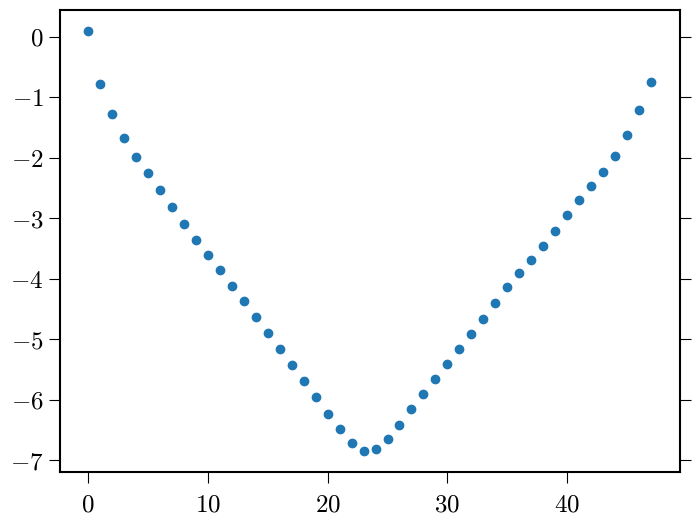

In [38]:
plt.scatter(np.arange(0,len(pionCorrProj)),np.log10(pionCorrProj.real))

Now we can compute the effective mass of a single gauge configuration:

In [39]:
# the more basic and more advanced forms for the effective mass
def calcEnergyIndividual(corr):
    E = []
    for i in range(0,len(corr)-1):
        E.append(np.log(corr[i]/corr[i+1]))
    return np.array(E)
def emMeson(corr):
    corrMean = corr
    E = []
    for i in range(1,len(corrMean)-1):
        E.append(np.arccosh((corrMean[i-1]+corrMean[i+1])/(2*corrMean[i])))
    return np.array(E)
def emBaryon(corr):
    corrMean = corr
    E = []
    for i in range(1,len(corrMean)-1):
        E.append(np.arcsinh((corrMean[i-1]-corrMean[i+1])/(2*corrMean[i])))
    return np.array(E)

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


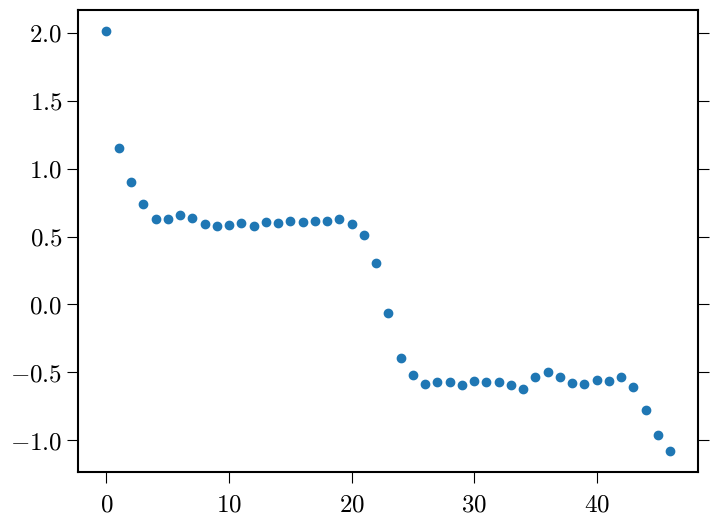

In [40]:
effectiveMassPion = calcEnergyIndividual(pionCorrProj)
# if plotting emMeson, need to do np.arange(0,len(pionCorrProj)-2
plt.scatter(np.arange(0,len(pionCorrProj)-1),effectiveMassPion)

For nonzero momentum, we weight our slice() summation by an operator P representing $e^{i\vec{x}\cdot\vec{p}}$

In [41]:
momentum = 1
L = prop.grid.fdimensions[0]
p = momentum*2.0 * np.pi * np.array([1, 0, 0, 0]) / L
P = g.exp_ixp(p)
PionCorrMomentum1 = g.slice(P*g.trace(g.adj(prop)*prop),3)

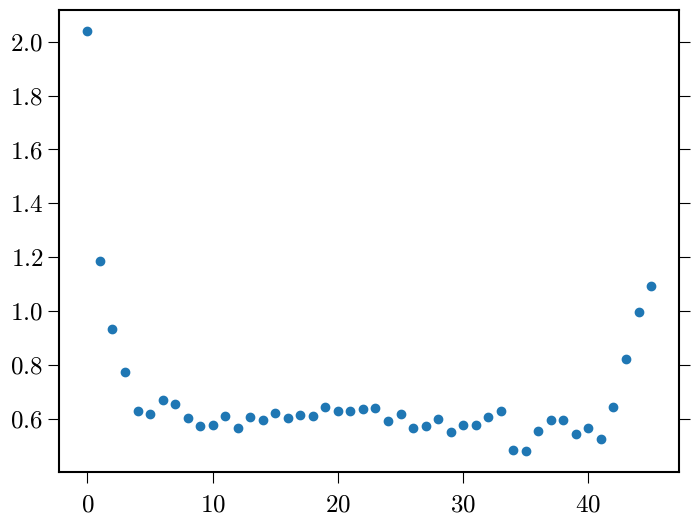

In [42]:
effectiveMassPion = emMeson(pionCorrProj)
plt.scatter(np.arange(0,len(pionCorrProj)-2),effectiveMassPion)

For the proton correlation function (and other baryons in general), there is a helpful $\verb|diquark|$ function to make things a bit easier.

Explicitly, $\verb|diquark|(S_1,S_2)_{a,a',\alpha,\beta}=\epsilon_{abc}\epsilon_{a'b'c'}S_{1,b,b',\alpha,\alpha'}S_{2,c,c',\beta,\alpha'}$.

Then, after working out all the relevant Wick contractions, the proton correlation can be written as, with $\text{Tr}_c$ representing a color trace, $\text{Tr}_s$ representing a spin trace, the charge conjugation matrix in our basis is $C_{\alpha\beta}=i\gamma_{1,\alpha,\alpha'}\gamma_{3,\alpha',\beta}$ (working in a basis where the spatial gammas are 0,1,2 and time gamma is 3), and $S$ is the propagator, with tensor multiplication implicit in the argument of diquark:

$\text{Tr}_c[\text{Tr}_s(\verb|diquark|(SC\gamma_5,C\gamma_5S))*\text{Tr}_s(S\frac{1}{2}(1+\gamma_3))]+\text{Tr}[\verb|diquark|(SC\gamma_5,C\gamma_5S)S\frac{1}{2}(1+\gamma_3)]$

In [43]:
def protonCorrelatorTwoPoint(prop,P):
    C = 1j*g.gamma[1].tensor()*g.gamma[3].tensor()
    Gamma = C*g.gamma[5].tensor()

    Pp = (g.gamma["I"].tensor() + g.gamma[3].tensor())*0.5

    q1p = g(prop * Pp)
    dq = g.qcd.baryon.diquark(g(prop*Gamma),g(Gamma*prop))
    results1 = g.slice(P*g.color_trace(g.spin_trace(dq) * g.spin_trace(q1p) + g.spin_trace(dq*q1p)),3)
    return results1

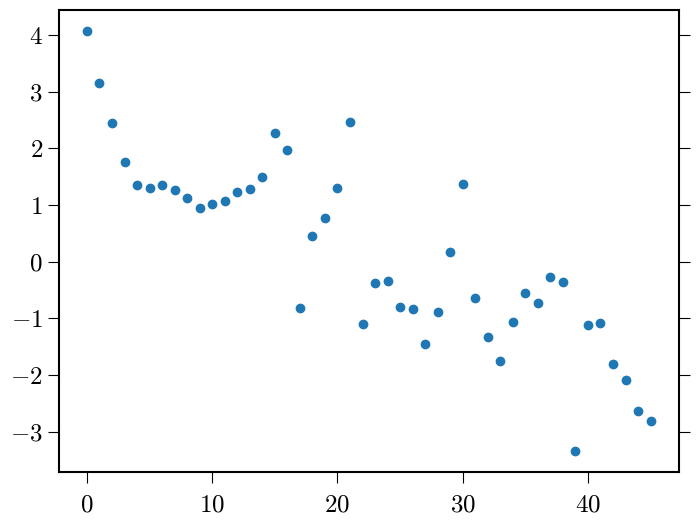

In [44]:
# Now plot
momentum = 0
p = momentum*2.0 * np.pi * np.array([1, 0, 0, 0]) / L
P = g.exp_ixp(p)
protonTwoPoint = np.array(protonCorrelatorTwoPoint(prop,P))
effectiveMassProton = emBaryon(protonTwoPoint)
plt.scatter(np.arange(0,len(protonTwoPoint)-2),effectiveMassProton)

## Three point functions of operator insertion <a name="threepoint"></a>

In our paper, we compute as a function of sink time. We therefore compute the sequential propagator required to compute the three point function at a fixed source momentum (either $0,1$ or $2$). For our operator insertion, we use $\gamma_3=\gamma_t$.

Explicitly, in this example, we compute $\text{Tr} [\pi^\dagger(\vec{0},t)V_3\pi(\vec{x}=0,t)]$ which projects for sufficiently separated $T/2\gg t\gg\tau$

We then invert the sequential propagator using the same propagator inversion function defined previously.

In [45]:
def sequentialProp(momentum,L,U,prop,t_op):
    grid = U[0].grid
    src_seq = g.mspincolor(grid)
    src_seq[:] = 0
    p = momentum*2.0 * np.pi * np.array([1, 0, 0, 0]) / L
    P = g.exp_ixp(p)
    src_seq[:, :, :, t_op] = prop[:, :, :, t_op]
    src_seq@=P*g.gamma[3]*src_seq
    prop_seq = propGeneration(U,src_seq)[0]
    return prop_seq

In [46]:
# Just collecting everything we did previously
def propGeneration(gauge,source):
    mass = -0.2450
    csw = 1.24930970916466
    parameters = {
                    "mass":mass,
                    "boundary_phases":[1,1,1,-1],
                    "csw_t":csw,
                    "csw_r":csw,
                    "xi_0":1,
                    "nu":1,
                    "isAnisotropic":False
                    }
    U = gauge
    # commenting out below because we've already smeared U!
    #sm = g.qcd.gauge.smear.stout(rho=0.125)
    #U2 = sm(U)
    U2 = U
    D_m = g.qcd.fermion.wilson_clover(U2, parameters)
    inv = g.algorithms.inverter
    inv_pc = inv.preconditioned
    pc = g.qcd.fermion.preconditioner
    print("creating inverter")
    fgcr = inv.fgcr({"eps": 1e-12, "maxiter": 1024, "restartlen": 8})
    inv2 = inv_pc(pc.eo2(), fgcr)
    inv2_w = inv2(D_m)
    grid = U2[0].grid
    src = source
    t0 = 0
    print("starting inverter")
   # g.create.point(src, (0,0,0,0))
    prop_xy = g(inv2_w * src)
    return [prop_xy,U,t0]

In [47]:
#invert with momentum zero
prop_seq = sequentialProp(0,L,U,prop,8)

creating inverter
starting inverter
GPT :     183.181989 s : fgcr: converged in 260 iterations;  computed squared residual 1.989567e-29 / 2.192552e-29;  true squared residual 1.989569e-29 / 2.192552e-29
GPT :     190.607297 s : fgcr: converged in 258 iterations;  computed squared residual 7.275473e-29 / 7.686733e-29;  true squared residual 7.275470e-29 / 7.686733e-29
GPT :     198.289939 s : fgcr: converged in 261 iterations;  computed squared residual 3.760520e-29 / 4.406023e-29;  true squared residual 3.760521e-29 / 4.406023e-29
GPT :     205.707013 s : fgcr: converged in 260 iterations;  computed squared residual 1.143196e-28 / 1.230439e-28;  true squared residual 1.143196e-28 / 1.230439e-28
GPT :     213.323030 s : fgcr: converged in 258 iterations;  computed squared residual 2.677531e-29 / 2.686429e-29;  true squared residual 2.677533e-29 / 2.686429e-29
GPT :     220.680992 s : fgcr: converged in 258 iterations;  computed squared residual 4.994183e-29 / 5.340544e-29;  true squared

In [48]:
g.save("prop_seqExample{}".format(0),prop_seq)

GPT :     268.253136 s : Switching view to [1,1,1,1]/Write
GPT :     272.456105 s : Wrote 1.42383 GB at 0.338767 GB/s (0.490973 GB/s for distribution, 26.1438 GB/s for checksum, 1.15248 GB/s for writing, 1 views per node)
GPT :     272.693320 s : Completed writing prop_seqExample0 in 4.60444 s


In [49]:
pionThreePoint = np.array(g.slice(g.trace(g.adj(prop)*prop_seq),3))

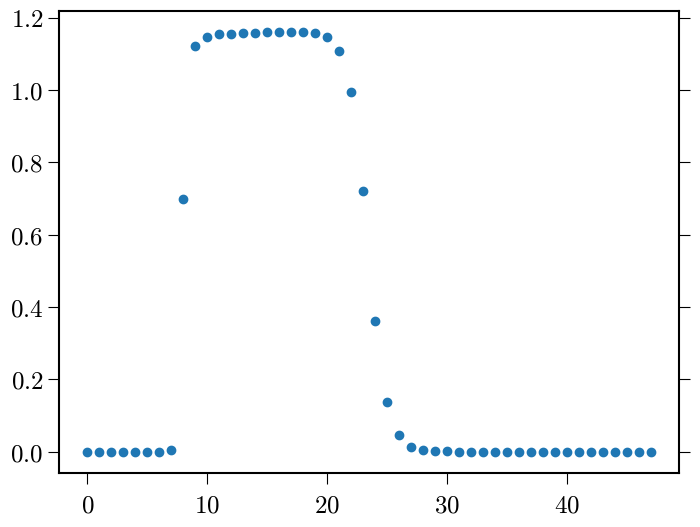

In [50]:
# Just as expected!
plt.scatter(np.arange(0,48),pionThreePoint/pionCorrProj)

Of course, in our actual simulations, we use 100 gauge configurations, and then compute error bars using bootstrap sampling